In [1]:
import pandas as pd
import numpy as np
import re

%matplotlib inline
import seaborn as sns
import matplotlib.pyplot as plt
sns.set_style('white')
sns.set_palette('muted')

# Pandas Settings
import warnings
warnings.filterwarnings("ignore")
pd.set_option('precision', 2)

## Import and Cleanse

In [2]:
df = pd.read_csv('data/books.csv')

In [3]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1043 entries, 0 to 1042
Data columns (total 59 columns):
Unnamed: 0                1043 non-null int64

Dewey Decimal
           237 non-null object

Publication date
        873 non-null object

Published in English
    27 non-null object
Alma mater                4 non-null object
Artists                   1 non-null object
Audio read by             49 non-null object
Author                    1023 non-null object
Authors                   1 non-null object
Award                     13 non-null object
Awards                    30 non-null object
Born                      15 non-null object
Children                  1 non-null object
Citizenship               1 non-null object
Colorist                  1 non-null object
Country                   959 non-null object
Cover artist              504 non-null object
Date                      1 non-null object
Date of publication       1 non-null object
Died                      3 non-null ob

In [4]:
df.columns = df.columns.str.lower()
df.columns = df.columns.str.replace(' ','_')

In [5]:
keep = ['author', 'country','genre','isbn','language','pages',
        'publisher','summary','title','ratings_text','ratings_count','product_url']

In [6]:
df = df[keep]

In [7]:
df.shape

(1043, 12)

In [8]:
df.head()

,author,country,genre,isbn,language,pages,publisher,summary,title,ratings_text,ratings_count,product_url
0,David Anthony Durham,United States,Fantasy fiction novel,0-385-50606-6,English,592 pp,Doubleday,Acacia: The War with the Mein is a 2007 novel ...,Acacia: The War with the Mein,NaN,NaN,NaN
1,Sir Henry Newbolt,United Kingdom,Fantasy novel,NaN,English,362 pp.,William Blackwood and Sons,Aladore is a classic allegorical fantasy novel...,Aladore,NaN,NaN,NaN
2,Lewis Carroll,United Kingdom,Fiction,NaN,English,NaN,Macmillan,Alice's Adventures in Wonderland (commonly sho...,Alice's Adventures in Wonderland,NaN,NaN,https://www.amazon.com/3dRose-mug_193746_1-Nan...
3,Patricia A. McKillip,United States,Fantasy novel,"0-441-01130-6 (first edition, hardback)",English,"314 (first edition, hardback)",Ace Books,Alphabet of Thorn is a 2004 fantasy novel writ...,Alphabet of Thorn,NaN,NaN,NaN
4,Michael Chabon,United States,Historical fiction,0-679-45004-1,English,639 pp,Random House,The Amazing Adventures of Kavalier & Clay is a...,The Amazing Adventures of Kavalier & Clay,NaN,NaN,NaN


### Pages

In [9]:
df['pages'] = df['pages'].str.extract('(\d+)')

In [10]:
df['pages'] = pd.to_numeric(df['pages'], errors='coerce')

In [11]:
df.pages.fillna(0,inplace=True)

In [12]:
df['pages'] = df.pages.astype(int)

In [13]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1043 entries, 0 to 1042
Data columns (total 12 columns):
author           1023 non-null object
country          959 non-null object
genre            1003 non-null object
isbn             639 non-null object
language         987 non-null object
pages            1043 non-null int64
publisher        883 non-null object
summary          1043 non-null object
title            1026 non-null object
ratings_text     58 non-null object
ratings_count    66 non-null object
product_url      90 non-null object
dtypes: int64(1), object(11)
memory usage: 97.9+ KB


### Ratings

In [14]:
df['clean_rating'] = df['ratings_text'].str.extract('(\d.\d)')

In [15]:
df['clean_rating'] = df.clean_rating.fillna(0)

In [16]:
df['clean_rating'] = df.clean_rating.astype(float)

In [17]:
df['clean_rating_count'] = df.ratings_count.fillna(0)

In [18]:
df.clean_rating_count.value_counts()

0        977
1         13
98         3
85         2
62         2
84         2
38         2
4          2
46         1
193        1
136        1
206        1
2          1
13         1
1,834      1
409        1
704        1
459        1
48         1
428        1
81         1
116        1
122        1
173        1
433        1
1,811      1
23         1
5,334      1
165        1
1,253      1
348        1
88         1
51         1
45         1
133        1
1,520      1
299        1
587        1
127        1
1,835      1
1,034      1
58         1
179        1
35         1
194        1
798        1
18         1
78         1
Name: clean_rating_count, dtype: int64

In [19]:
df['clean_rating_count'] = df.clean_rating_count.str.replace(',','')

In [20]:
df['clean_rating_count'] = df.clean_rating_count.astype(float)

In [21]:
df.drop(['ratings_text','ratings_count'],axis=1,inplace=True)

### Genres

Since There are so many genres here I am just going to keep it sime and say that any genre that contains the words Science Fiction should be set to science fiction genre, everything else will be set to Fantasy. 

I am choosing to do this since I scraped the wikipedia Science Fiction and Fantasy lists for these books.

In [22]:
df.genre.value_counts()[:10]

Science fiction             334
Science fiction novel       116
Fantasy                      81
Fantasy novel                56
Science fantasy              36
Epic fantasy                 11
science-fiction novel        10
Military science fiction      9
science fiction               7
Comic science fiction         6
Name: genre, dtype: int64

In [23]:
df['genre'] = df.genre.fillna('None')

In [24]:
def replace_genre(s):
    s = s.lower()
    if 'science' in s and 'fiction' in s:
        return 'Science Fiction'
    elif 'none' in s:
        return 'No Genre'
    else:
        return 'Fantasy'

In [25]:
df['genre'] = df.genre.apply(replace_genre)

In [26]:
df.genre.value_counts()

Science Fiction    628
Fantasy            375
No Genre            40
Name: genre, dtype: int64

### Duplicates

I am dropping any rows that are missing the author or title as those are going to be very important for my recommendation engine.

In [27]:
df = df.dropna(subset=['title','author'])

I do not want books duplicate titles so I will see if there are any duplicates and chose which to keep.

In [28]:
df.title.duplicated().value_counts()

False    965
True      56
Name: title, dtype: int64

In [29]:
df.sort_values(by=['title','clean_rating_count'],ascending= False,inplace=True)

In [30]:
df.drop_duplicates(subset=['title'],keep='first',inplace=True)

## Exploratory Data Analysis

### Number of Pages

In [31]:
bins = int(np.sqrt(len(df)))

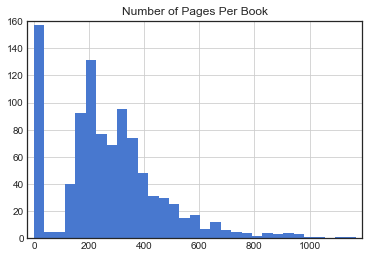

In [32]:
df.pages.hist(bins = bins)
plt.title('Number of Pages Per Book')
plt.margins(.02);

In [33]:
df.pages.describe()

count     965.00
mean      273.02
std       194.38
min         0.00
25%       160.00
50%       254.00
75%       368.00
max      1168.00
Name: pages, dtype: float64

In [34]:
df.pages.value_counts().sort_index()[:5]

0     155
7       1
30      1
46      1
47      1
Name: pages, dtype: int64

### Top Books by Author

In [35]:
top_authors = df.author.value_counts().sort_values(ascending=False)[:15].reset_index()
top_authors.columns = ['author','count']

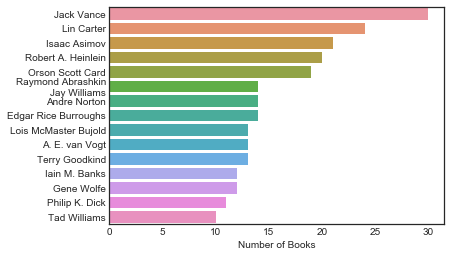

In [36]:
sns.barplot(x = 'count',y='author',data=top_authors)
plt.xlabel('Number of Books')
plt.ylabel('');

### Ratings Distribution

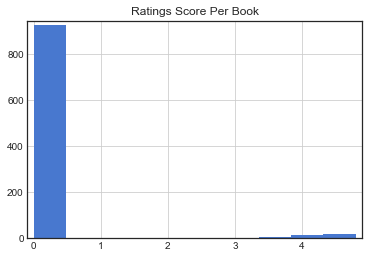

In [37]:
df.clean_rating.hist()
plt.margins(.02)
plt.title('Ratings Score Per Book');

Text(0.5,1,'Number of Ratings Per Book')

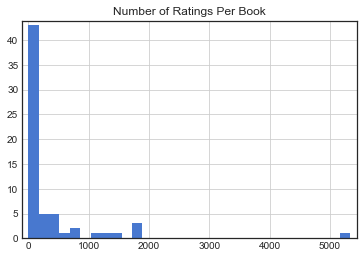

In [38]:
df.clean_rating_count.hist(bins=bins)
plt.margins(.02)
plt.title('Number of Ratings Per Book')

It looks like the majority of the books do not actually have ratings so I probably won't use these two features in the recommendation engine.

### Genres

In [39]:
genre_group = df.genre.value_counts().sort_values(ascending=False)

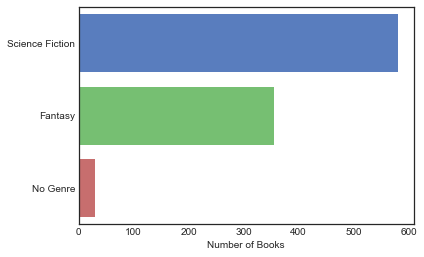

In [40]:
sns.barplot(y=genre_group.index, x=genre_group.values)
plt.xlabel('Number of Books')
plt.ylabel('');

So it looks like we have a majority of our data is science fiction, many of the book recommendations will probably skew to science fiction then.

Now I am going to export the cleaned data and create the recommendation engine in a separate notebook.

In [41]:
df.to_csv('data/cleaned_books.csv')